# Lesion Diagnosis Task

- Challenge paper: Skin Lesion Analysis Toward Melanoma
Detection 2018: A Challenge Hosted by the
International Skin Imaging Collaboration (ISIC) (https://arxiv.org/pdf/1902.03368.pdf)
  
- Dataset: Skin Cancer MNIST: HAM10000 (https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000?select=hmnist_28_28_L.csv)

## Task goal
Submit automated predictions of disease classification within dermoscopic images.

Possible disease categories are:
1.   Melanoma 
2.   Melanocytic nevus
3.   Basal cell carcinoma
4.   Actinic keratosis / Bowen’s disease (intraepithelial carcinoma)
5.   Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
6.   Dermatofibroma
7.   Vascular lesion

![data](https://challenge2018.isic-archive.com/wp-content/uploads/2018/04/task3.png)

## Dataset Description

The lesion images come from the **HAM10000 Dataset**, and were acquired with a variety of dermatoscope types, from all anatomic sites (excluding mucosa and nails), from a historical sample of patients presented for **skin cancer screening**, from several different institutions. Images were collected with approval of the Ethics Review Committee of University of Queensland (Protocol-No. 2017001223) and Medical University of Vienna (Protocol-No. 1804/2017).

The distribution of disease states represent a modified “real world” setting whereby there are more benign lesions than malignant lesions, but an over-representation of malignancies.

## Setup

In [ ]:
! pip install kaggle imbalanced-learn delayed --quiet

     |████████████████████████████████| 92kB 4.0MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 


In [ ]:
# import libraries
import shutil
import os

from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, plot_precision_recall_curve
from sklearn.preprocessing import StandardScaler

# Colab library to upload files to notebook
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns
import matplotlib.image as mpimg
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pydot
import sklearn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image, ImageOps

# PCA
from sklearn.decomposition import PCA
import cv2

# balancing dataset
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# gridsearch
from sklearn.model_selection import ParameterGrid

# hide warnings
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

import pickle


import gc

IMAGE_SIZE = 38


In [ ]:
def save_pickle(obj, filename, drive=True):
  path = ""
  if drive:
    path = "/gdrive/My Drive/ML/Dataset"
    
  filehandler = open(f"{path}/{filename}.obj","wb")
  pickle.dump(obj, filehandler)
  filehandler.close()


def open_pickle(filename, drive=True):
  if drive:
    path = "/gdrive/My Drive/ML/Dataset"

  data = open(f"{path}/{filename}.obj",'rb')
  object_file = pickle.load(data)
  data.close()
  return object_file


def load_dataset(from_drive=True, balanced=False):
  if from_drive and not balanced:
    return open_pickle(filename="unbalanced_dataset_80_80", drive=True)
  if from_drive and balanced:
    return open_pickle(filename="balanced_dataset_80_80", drive=True)
  else:
    !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
    !unzip skin-cancer-mnist-ham10000.zip
    # move files in a single directory
    # from 2 directory to a single directory
    source_dir = '/content/HAM10000_images_part_2'
    target_dir = '/content/HAM10000_images_part_1'
    
    file_names = os.listdir(source_dir)
    
    for file_name in file_names:
      shutil.move(os.path.join(source_dir, file_name), target_dir)

## Load data and mount gdrive
Load data from [kaggle repository](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000) and mount Google Drive to save models and data

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

PATH = "../gdrive/MyDrive/ML/"

Mounted at /gdrive


In [ ]:
# Upload kaggle API key file
uploaded = files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#load_dataset(from_drive=True, balanced=False)
load_dataset(from_drive=False)

## Show data

The files given by HAM10000 dataset are:
- **metadata file**: contains all patient attribute related with disease and the **target** column
- **images** 

In [ ]:
metadata = pd.read_csv(f"./HAM10000_metadata.csv")
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}

In [ ]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.5])

fig.add_trace(go.Bar(
            x=metadata['sex'].value_counts().index, 
            y=metadata['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=metadata['localization'].value_counts().index, 
            y=metadata['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=metadata['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=metadata['dx'].value_counts().index.map(lesion_type_dict.get), 
            y=metadata['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data after augmentation', height=800)

fig.show()

In [ ]:
def show_images(imgs, path=""):
  _, axs = plt.subplots(4, 4, figsize=(12, 12))
  axs = axs.flatten()
  for img, ax in zip(imgs, axs):
    image = mpimg.imread(f"{path}/{img}")
    ax.set_title(metadata[metadata["image_id"]==img.split(".")[0]].values[0][2])
    ax.imshow(image)
  plt.show()

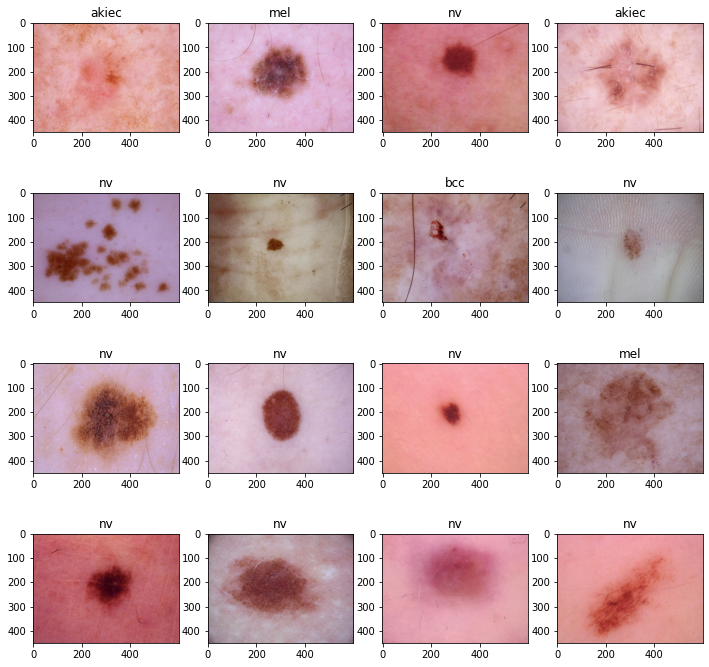

In [ ]:
# images from HAM10000 dataset
show_images(os.listdir("/content/HAM10000_images_part_1/")[0:30], path="/content/HAM10000_images_part_1/")

## PCA 

Principal Component Analysis (PCA), is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.

So to sum up, the idea of PCA is simple — reduce the number of variables of a data set, while preserving as much information as possible.


$S\lambda = \lambda u_1$

where $S$ is the dataset covariance matrix, $u_1$ is unitary vector and lambda is the lagrangian coefficient. The best $u_1$ solution is then the **eigenvector** associated to the **maximum eigenvalue of the cov matrix $S$**.


In [ ]:
def pca(M,vec,numpc=0):
    # extract eigenvectors corresponding to the first numpc eigenvalues, this is a basis in a space of dimension numpc
    basis = vec[:,range(numpc)]
    # projection of the data in the new space of dimension numpc
    projections = np.dot(M,basis) 
    #return eigenvectors and projections
    return basis, projections


def get_eigen(A):
    # computing eigenvalues and eigenvectors of the covariance matrix
    # of the set of vectors corresponding to rows of A
    # compute mean for each column (feature)
    means = np.mean(A,axis=0)
    # subtract the mean (along columns): each feature has now zero mean
    M = (A-means)
    # derive the covariance matrix of the set of vectors corresponding to rows of A
    c = np.cov(M, rowvar=0)
    # compute the sets of eigenvalues and eigenvectors of the covariance matrix
    [evals,evects] = np.linalg.eig(c)
    # compute indices of eigenvalues sorted in descending order
    idx = np.argsort(evals) 
    # derive indices of eigenvalues sorted in ascending order
    idx = idx[::-1]       

    # sort eigenvectors (columns of evects) according to the sorted eigenvalues
    evects = evects[:,idx]
    # sort eigenvalues in ascending order
    evals = evals[idx] 
    return evals, evects, M

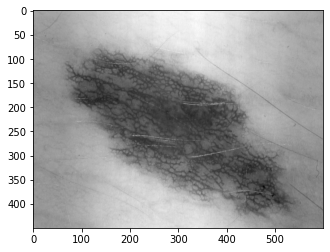

In [ ]:
img =plt.imread('/content/HAM10000_images_part_1/ISIC_0024308.jpg') # load an image
bw = np.mean(img,2)
full_pc = bw.shape[0]
val,vec,bw_c=get_eigen(bw)
plt.rcParams["axes.grid"] = False
plt.imshow(bw_c, cmap='gray')

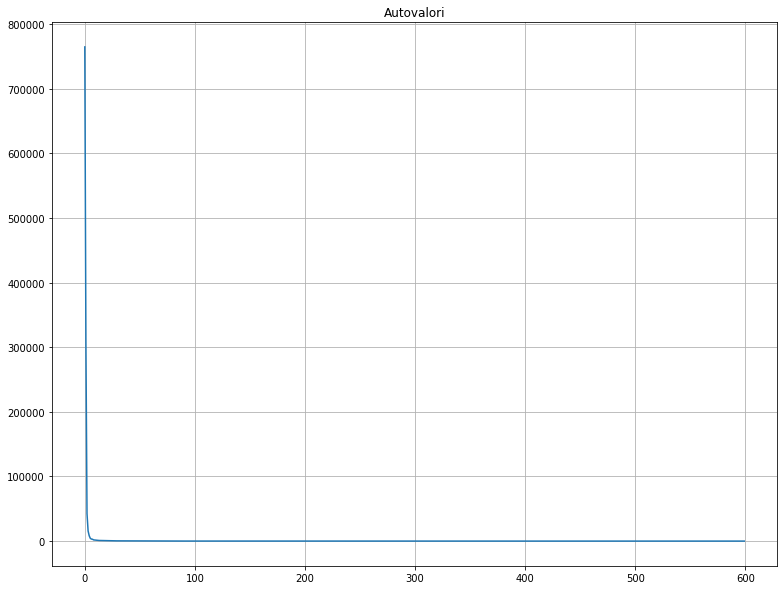

In [ ]:
fig = plt.figure(figsize=(13,10))
ax = fig.gca()
ax.plot(val)
ax.grid()
plt.title('Autovalori')
plt.show()

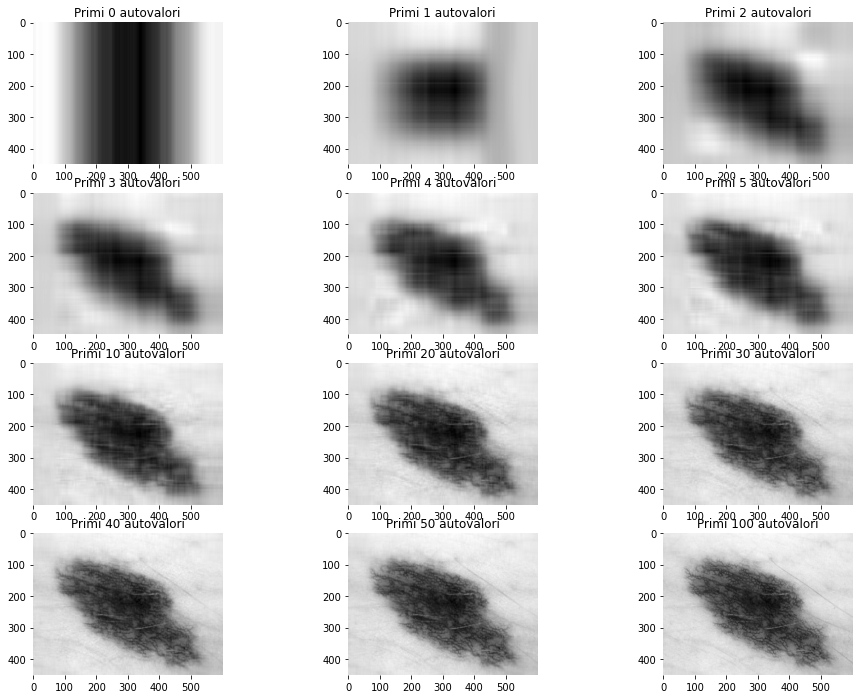

In [ ]:
import numpy.linalg as linalg
i = 1
fig = plt.figure(figsize=(16,12))
fig.patch.set_facecolor('white')
for numpc in [0,1,2,3,4,5]+list(range(10,51,10))+[100]: # 0 10 20 ... full_pc
    # compute projections on a space of dimension numpc
    coeff, score = pca(bw_c,vec,numpc)
    # compute projections back into a space of original dimension
    bw_rec = np.dot(score,coeff.T) 
    # add back feature means
    bw_rec = bw_rec+np.mean(bw,axis=0) 
    # difference in Frobenius norm between original and compressed images
    # plot image
    ax = plt.subplot(4,3,i,frame_on=False)
    i += 1 
    plt.imshow(np.asarray(bw_rec, dtype=np.float32), cmap='gray')
    plt.title('Primi '+str(numpc)+' autovalori')

Text(0.5, 1.0, 'Resized')

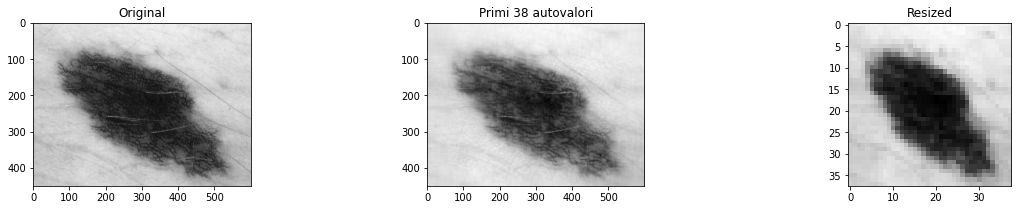

In [ ]:
%matplotlib inline
import numpy.linalg as linalg

img =plt.imread('/content/HAM10000_images_part_1/ISIC_0024308.jpg') # load an image

bw = np.mean(img,2)
full_pc = bw.shape[0]
val,vec,bw_c=get_eigen(bw)
plt.rcParams["figure.figsize"] = (20,3)
numpc = 38
# compute projections on a space of dimension numpc
coeff, score = pca(bw_c, vec, numpc)
## compute projections back into a space of original dimension
bw_rec = np.dot(score,coeff.T) 
# add back feature means
bw_rec = bw_rec+np.mean(bw,axis=0)
# difference in Frobenius norm between original and compressed images
# plot image
fig, (ax1,ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(plt.imread('/content/HAM10000_images_part_1/ISIC_0024308.jpg')[:, :, -1], cmap="gray")
ax1.set_title("Original")

ax2.imshow(np.asarray(bw_rec, dtype=np.float32), cmap='gray')
ax2.set_title('Primi '+str(numpc)+' autovalori')

image = Image.open('/content/HAM10000_images_part_1/ISIC_0024308.jpg')
image = image.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
image = np.array(image)
ax3.imshow(image[:,:,-1], cmap="gray")
ax3.set_title("Resized")

# Data Analysis
In this section we discuss about the distribution of the dataset w.r.t. the target column, and we analyze the structure of the images. 

Our aim is to understand the dataset distribution and composition in order to manipulate the data in the right way. We investigate about target class distribution, image sizes and pixel distributions.

### Target class distribution
The target column "dx" distribution. The target column contains the disease type. 

The distribution of the column shows the imbalance derived from the first class, the number of example of "nv" class is about 5 times greather then the second class with more examples. 

In [ ]:
# target class distribution
target_dist = dict(metadata["dx"].value_counts())

# create dataframe
target_dist_df = pd.DataFrame({"target":list(target_dist.keys()), "count":list(target_dist.values())})

# total examples
total_examples = np.sum(target_dist_df["count"].values)

# plot distribution
px.bar(x="target", y="count", data_frame=target_dist_df)

In [ ]:
target_dist_df["percentage"] = (target_dist_df["count"] * 100) / total_examples
target_dist_df

,target,count,percentage
0,nv,6705,66.949576
1,mel,1113,11.113330
2,bkl,1099,10.973540
3,bcc,514,5.132302
4,akiec,327,3.265102
5,vasc,142,1.417873
6,df,115,1.148278


### Images properties 
- Image sizes
- Channels
- Pixel distributions

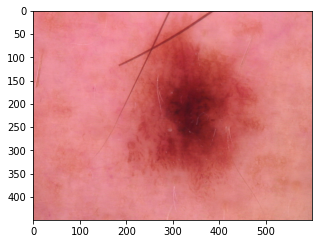

In [ ]:
pic = mpimg.imread("/content/HAM10000_images_part_1/ISIC_0024306.jpg")
plt.figure(figsize = (5,5))
plt.imshow(pic)

In [ ]:
print(f'Type of the image : {type(pic)}') 
print(f'Shape of the image : {pic.shape}') 
print(f'Image Hight {pic.shape[0]}') 
print(f'Image Width {pic.shape[1]}') 
print(f'Dimension of Image {pic.ndim}')

Type of the image : <class 'numpy.ndarray'>
Shape of the image : (450, 600, 3)
Image Hight 450
Image Width 600
Dimension of Image 3


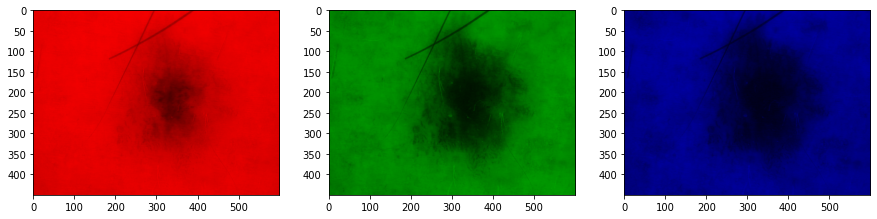

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))  
for c, ax in zip(range(3), ax):     
     # create zero matrix        
     split_img = np.zeros(pic.shape, dtype="uint8") 
     # 'dtype' by default: 'numpy.float64'  
     # assing each channel      
     split_img[ :, :, c] = pic[ :, :, c] # display each channel     
     ax.imshow(split_img)

### Pixels distribution

Images are stored as pixels values, each pixel value represents a color intensity value. Histograms are frequency distribution of these intensity values that occur in an image.

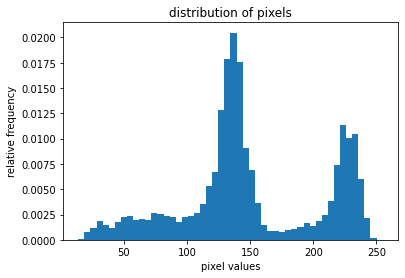

In [ ]:
plt.hist(np.array(pic).ravel(), bins=50, density=True);
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

## Labels encoding

In order to execute the skin disease classification task we need to encode the labels of target column. We use a string to integer mapping for each disease target.  

$Label: String -> Integer$



---

 Class | Label 
 --|--
 bkl | 0  |  
 nv |  1 |  
 df | 2  |  
 mel | 3  |
 vasc | 4  |  
 bcc |   5|
 akiec |  6 |


In [ ]:
classes = list(metadata["dx"].unique())

def labels_to_integer(row):
  return classes.index(row)

In [ ]:
classes

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

In [ ]:
metadata["label"] = metadata["dx"].apply(labels_to_integer) 
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,6
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,6
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,6
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,6


# Feature engineering

Feature engineering efforts mainly have two goals:

- Preparing the proper input dataset, compatible with the machine learning algorithm requirements.
- Improving the performance of machine learning models.


In this step we try to avoid the problems derived from the **imbalanced dataset distribution**. Expecially in our case study there is a strong target class imbalance.  

In [ ]:
def load_images(root_dir, size=80):
  X, Y = [], []
  for img in tqdm(os.listdir(root_dir)):
    image = Image.open(f"{root_dir}/{img}")
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
    image = np.array(image)
    target = metadata[metadata["image_id"]==img.split(".")[0]]["label"].values[0]
    X.append(image)
    Y.append(target)
  return np.array(X), np.array(Y)

In [ ]:
X, Y = load_images("/content/HAM10000_images_part_1", size=IMAGE_SIZE)
#X, Y = load_dataset(from_drive=True, balanced=False)

100%|██████████| 10015/10015 [02:38<00:00, 63.17it/s]


In [ ]:
X.shape

(10015, 38, 38, 3)

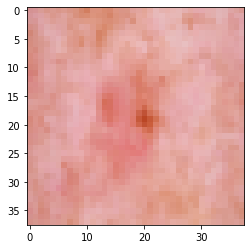

In [ ]:
plt.imshow(X[0])

## Train and test split

In this section we split the data that we use in our experiments.
The dataset contains more than **10.000 images**.

We choose a **70/30** train-test splitting, we also split train example in train and validation set using a **90/10** split. Moreover we decide to use a **shuffle** strategy at data loading time.


In [ ]:
# Hyperparameters
TEST_SIZE = .3
VAL_SIZE = .1

In [ ]:
# Train and test splitting
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=VAL_SIZE, shuffle=True)

We use pickle to save experiments data to save memory space.

In [ ]:
save_pickle((X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3),Y_train), "train_data")
save_pickle((X_val,Y_val), "val_data")
save_pickle((X_test,Y_test), "test_data")

In [ ]:
X_train, Y_train = open_pickle("train_data")
X_test, Y_test = open_pickle("test_data")
X_val, Y_val = open_pickle("val_data")

### Data balancing

**Imbalanced Dataset**: If there is the very high different between the positive values and negative values. Then we can say our dataset in Imbalance Dataset. In general is an **unequal distribution of classes within a dataset**.

![balanced](https://miro.medium.com/max/900/1*zsyN08VVrgHbAEdvv27Pyw.png)

There is a big problem with imbalanced datasets, the model trained on that dataset are **biased**.

- Good performances on a specific class (most examples in the dataset)
- Bad performances in other classes
- No generalization


## Resampling (Oversampling and Undersampling)

- **Undersampling** is the process where you randomly delete some of the observations from the majority class in order to match the numbers with the minority class.

- **Oversampling** process is a little more complicated than undersampling. It is the process of generating synthetic data that tries to randomly generate a sample of the attributes from observations in the minority class. There are a number of methods used to oversample a dataset for a typical classification problem.


![resampling](https://miro.medium.com/max/4888/1*ENvt_PTaH5v4BXZfd-3pMA.png)

In our project we use both Oversampling and Undersampling with a specific pipeline:

- RandomUnderSampler *(Undersampling)*: decreasing to K the number of examples of the class with more examples (CLASS 1).

- RandomOverSampling *(Oversampling)*: increase to K the number of small classes.

### Random Undersampling

The most easy undersampling method, we remove at random examples from the class with more examples.

### Random Oversampling

In this method we generate new examples. We sample randomly examples from the same class to augment the number of class examples. We adopt a data augmentation strategy to avoid data redundancy derived from this method (we see it later).   

In [ ]:
def combine_resampling(X, Y, undersampling=True, oversampling=True, K=2500):
  if undersampling and oversampling:
    sampler = make_pipeline(
        RandomUnderSampler(random_state=0, sampling_strategy={1: K}),
        RandomOverSampler(random_state=0)
    )
  if undersampling and not oversampling:
    sampler = make_pipeline(
    RandomUnderSampler(random_state=0, sampling_strategy={1: K}))

  X_resampled, Y_resampled = sampler.fit_resample(X.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y)

  return X_resampled, Y_resampled

In [ ]:
X_balanced, Y_balanced = combine_resampling(X_train, Y_train, undersampling=True, oversampling=False, K=2500)
save_pickle((X_balanced.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3),Y_balanced), "train_data_undersampled")

In [ ]:
X_balanced, Y_balanced = combine_resampling(X_train, Y_train)
save_pickle((X_balanced.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3),Y_balanced), "train_data_combined")

In [ ]:
X_resampled, Y_resampled = open_pickle("train_data_combined")

counts = Counter(Y_resampled)
# create dataframe
target_dist_df = pd.DataFrame({"target":list(counts.keys()), "count":list(counts.values())})

# plot distribution
px.bar(x="target", y="count", data_frame=target_dist_df )

In [ ]:
def show_images(imgs, path=""):
  _, axs = plt.subplots(4, 4, figsize=(12, 12))
  axs = axs.flatten()
  for img, ax in zip(imgs, axs):
    ax.imshow(img)
  plt.show()

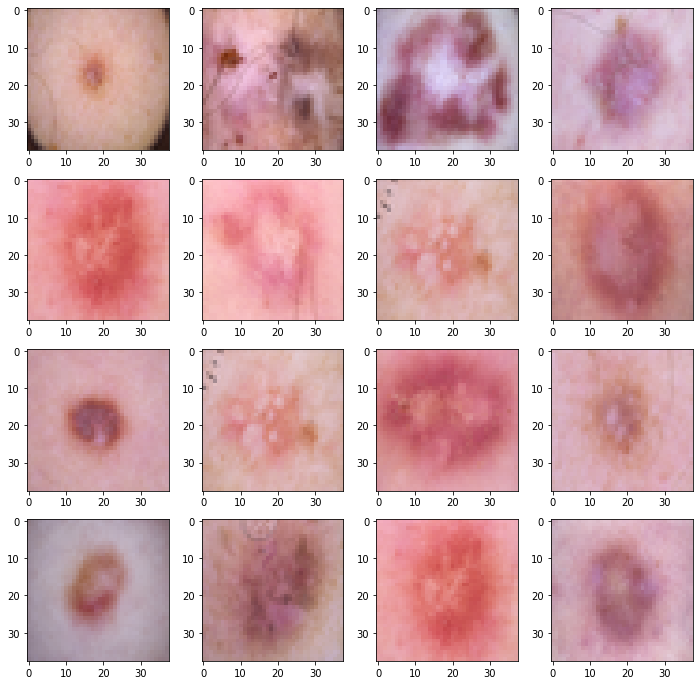

In [ ]:
# some images of syntetic examples sampled with RandomOverSampling
show_images(X_resampled[8000:])

# Experiments
We investigate our case study using different Machine Learning models. We start from a **dummy baseline model** that use a random function to predict the outcomes. Then we experiments the following models:

- **TRADITIONAL ML MODELS**
  - Softmax regression
  - Support Vector Machine

- **DEEP LEARNING**
  - Convolutional Neural Network

- **ENSAMBLE LEARNING (BOOSTING)**  
  - XGBoosting algorithm

We perform **model selection** step basing on model performances over our validation set using the **grid search algorithm** to find the best hyperpameters configuration.

**We use different training dataset** in order to investigate the balance data importance and the data augmentation effort to our task.

## Load experiments data

In [ ]:
# data load checkpoint base dataset
X_train, Y_train = open_pickle("train_data")
X_test, Y_test = open_pickle("test_data")
X_val, Y_val = open_pickle("val_data")

# undersampled dataset
X_train_undersampled, Y_train_undersampled = open_pickle("train_data_undersampled")

# resampled dataset (oversampling + undersampling)
X_train_combined, Y_train_combined = open_pickle("train_data_combined")

### Data augmentation

Data augmentation is a technique to artificially create new training data from existing training data. This is done by applying domain-specific techniques to examples from the training data that create new and different training examples.

Image data augmentation is perhaps the most well-known type of data augmentation and involves creating transformed versions of images in the training dataset that belong to the same class as the original image.

Transforms include a range of operations from the field of image manipulation, such as shifts, flips, zooms, and much more.

**We use data augmentation in 3 of our 4 datasets, excluding the base dataset (without resampling) to exploit the help of this strategy in term of performances and generalization.**  


In [ ]:
# data augmentation lib for traditional ML methods
import albumentations as A

transform = A.Compose(
    [
     A.RandomRotate90(),
     A.Transpose(),
     A.Rotate(p=.50),
     A.Blur(blur_limit=1, p=.3),
     A.RandomBrightness(),
     A.RandomContrast(),
     ])

def augment_image(img):
  return transform(image=img)['image']

def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)

Augmentation techniques:

1. **RandomRotate90**: Rotate the image randomly (90 degrees) with probability p=0.5 

2. **Transpose**: Transpose the image randomly (90 degrees) with probability p=0.5 

3. **Rotate**: Rotate the image randomly (random degrees) with probability p=0.5 

4. **Blur**: Add blur effect to image with probability p=0.3 (tuned)

5. **RandomBrightness**: Set a random image brightness

6. **RandomContrast**: Set a random image contrast

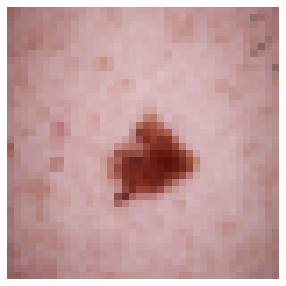

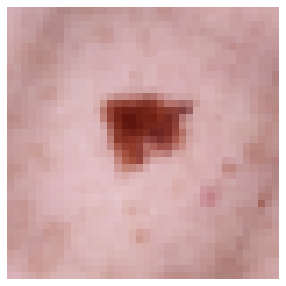

In [ ]:
# show augmented example
%matplotlib inline
visualize(X_train[90])
visualize(augment_image(X_train[90]))

In [ ]:
# augment training data
augmented_train = []
augmented_train_undersampled = []
augmented_train_combined = []


for x in tqdm(X_train):
  augmented_train.append(augment_image(x))


for us in tqdm(X_train_undersampled):
  augmented_train_undersampled.append(augment_image(us))

for c in tqdm(X_train_combined):
  augmented_train_combined.append(augment_image(c))


100%|██████████| 17500/17500 [00:02<00:00, 7217.71it/s]


In [ ]:
augmented_train = np.array(augmented_train)
augmented_train.shape

(9013, 38, 38, 3)

In [ ]:
metrics = sklearn.metrics.SCORERS.keys()
metrics

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

### Grid Search function

Grid-searching is the process of scanning the data to configure optimal parameters for a given model. Depending on the type of model utilized, certain parameters are necessary. 

Grid-searching does NOT only apply to one model type. Grid-searching can be applied across machine learning to calculate the best parameters to use for any given model. Grid-Search will build a model on each parameter combination possible. It iterates through every parameter combination and stores a model for each combination. 

![grid-searh](https://www.researchgate.net/profile/Michael-Jordan-3/publication/271771573/figure/fig4/AS:668513593217027@1536397469229/Illustration-of-naive-grid-search-for-a-single-model-family-with-two-hyperparameters.png)

In [ ]:
def grid_search(grid, model, X_train, X_val, Y_train, Y_val):
  grid_s = ParameterGrid(grid)
  precisions, recalls, f1s, accuracies, params = [], [], [], [], []  
  results = pd.DataFrame()
  for p in tqdm(grid_s):
    model.set_params(**p)
    # training
    model.fit(X_train, Y_train)

    # measure on validation set
    val_preds = model.predict(X_val)
    precisions.append(precision_score(val_preds, Y_val, average="macro"))
    recalls.append(recall_score(val_preds, Y_val, average="macro"))
    f1s.append(f1_score(val_preds, Y_val, average="macro"))
    accuracies.append(accuracy_score(val_preds, Y_val))
    params.append(p)

  results["params"] = params
  results["accuracy"] = accuracies
  results["precision"] = precisions
  results["recall"] = recalls
  results["f1"] = f1s


  return results

## Random Classifier - Baseline

Dummy model that randomly predict the class of examples. We use this model to use it like baseline for our models.

In [ ]:
from random import choice

In [ ]:
random_preds = []
for y in Y_test:
  random_preds.append(choice(range(0,7)))

random_test_results = pd.DataFrame()
random_test_results['accuracy'] = [accuracy_score(random_preds, Y_test)]
random_test_results['precision'] = [precision_score(random_preds, Y_test, average='macro')]
random_test_results['recall'] = [recall_score(random_preds, Y_test, average='macro')]
random_test_results['f1'] = [f1_score(random_preds, Y_test, average='macro')]

random_test_results

,accuracy,precision,recall,f1
0,0.138769,0.162621,0.142285,0.096141


In [ ]:
random_test_results.to_csv('/gdrive/My Drive/ML/random_test_results.csv')

## Traditional ML method

### Softmax regression

Softmax Regression is an extension of Logistic Regression approach to the case $K > 2$ where K is the number of classes. 


The matrix $W = (w_1, . . . , w_K)$ of model coefficients, of size $(d + 1) × K$
where $w_j$ is the $d + 1$-dimensional vector of coefficients for class $C_j$.


The cost function (log-likelihood) used in the softmax regression is:

$J(W) = \sum_{i=1}^n{\sum_{k=1}^K t_{ik}} \  log(\frac{e^{w_k^Tx_i}}{\sum_{r=1}^K e^{w_r^Tx_i} })$

So with Maximum likelihood we try to maximize the gradient of J(W) to find the best parameter configuration.



In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# logistic regression parameters
log_regression_parameters = {
    "solver":["lbfgs"],
    "C":[1, 0.8, 0.6, 0.4, 0.2]
}

datasets = {
    "base":(X_train.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_train, X_val.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_val), 
    "base_augmented":(augmented_train.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_train,  X_val.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_val), 
    "undersampled":(np.array(augmented_train_undersampled).reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_train_undersampled, X_val.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_val), 
    "combined":(np.array(augmented_train_combined).reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_train_combined, X_val.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_val)
    }

In [ ]:
# init the model
estimator = LogisticRegression()
results = {}


for d in datasets:
  r = grid_search(grid=log_regression_parameters, 
                      model=estimator, 
                      X_train=datasets[d][0], 
                      Y_train=datasets[d][1], 
                      X_val = datasets[d][2], 
                      Y_val=datasets[d][3]
                  )
  results[d] = r

100%|██████████| 5/5 [05:43<00:00, 68.71s/it]


In [ ]:
save_pickle(results, "logistic_regression_grid_search")

In [ ]:
results = open_pickle("logistic_regression_grid_search")

In [ ]:
for r in results:
  results[r]["dataset"] = r

all_models_results = pd.concat([
                                results["base"],
                                results["base_augmented"],
                                results["undersampled"],
                                results["combined"],
                                ])

all_models_results.sort_values("f1", ascending=False).to_csv("/gdrive/My Drive/ML/LogisticRegression/logistic_regression_datasets_performances.csv")
all_models_results.sort_values("f1", ascending=False)

,params,accuracy,precision,recall,f1,dataset
2,"{'C': 0.6, 'solver': 'lbfgs'}",0.503992,0.496472,0.310525,0.334497,combined
4,"{'C': 0.2, 'solver': 'lbfgs'}",0.499002,0.484187,0.309475,0.326067,combined
3,"{'C': 0.4, 'solver': 'lbfgs'}",0.499002,0.481477,0.306430,0.324734,combined
0,"{'C': 1, 'solver': 'lbfgs'}",0.491018,0.477855,0.308324,0.324464,combined
1,"{'C': 0.8, 'solver': 'lbfgs'}",0.482036,0.473452,0.302629,0.316426,combined
4,"{'C': 0.2, 'solver': 'lbfgs'}",0.627745,0.276878,0.363405,0.287867,undersampled
2,"{'C': 0.6, 'solver': 'lbfgs'}",0.614770,0.279351,0.319428,0.287124,undersampled
1,"{'C': 0.8, 'solver': 'lbfgs'}",0.629741,0.270888,0.333713,0.276452,undersampled
3,"{'C': 0.4, 'solver': 'lbfgs'}",0.693613,0.263598,0.416554,0.275730,base
1,"{'C': 0.8, 'solver': 'lbfgs'}",0.694611,0.258164,0.417341,0.272939,base


In [ ]:
def extract_C(row):
  return float(row.split(",")[0].split(":")[1].strip())

In [ ]:
all_models_results = pd.read_csv("/gdrive/My Drive/ML/LogisticRegression/logistic_regression_datasets_performances.csv")
all_models_results

In [ ]:
best_conf = all_models_results[all_models_results["dataset"]=="combined"]
best_conf["C"] = best_conf["params"].apply(extract_C)
best_conf = best_conf.sort_values("C") 
best_conf

,Unnamed: 0,params,accuracy,precision,recall,f1,dataset,C
1,4,"{'C': 0.2, 'solver': 'lbfgs'}",0.499002,0.484187,0.309475,0.326067,combined,0.2
2,3,"{'C': 0.4, 'solver': 'lbfgs'}",0.499002,0.481477,0.306430,0.324734,combined,0.4
0,2,"{'C': 0.6, 'solver': 'lbfgs'}",0.503992,0.496472,0.310525,0.334497,combined,0.6
4,1,"{'C': 0.8, 'solver': 'lbfgs'}",0.482036,0.473452,0.302629,0.316426,combined,0.8
3,0,"{'C': 1, 'solver': 'lbfgs'}",0.491018,0.477855,0.308324,0.324464,combined,1.0


Text(0, 0.5, 'f1-measure')

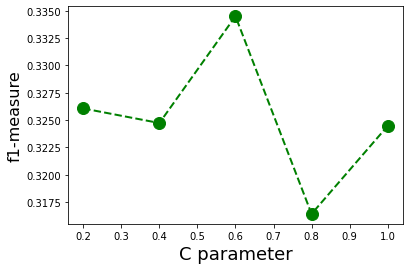

In [ ]:
plt.plot(best_conf["C"], best_conf["f1"].values, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.xlabel('C parameter', fontsize=18)
plt.ylabel('f1-measure', fontsize=16)

In [ ]:
import ast

In [ ]:
# best model
best_lr_model = all_models_results.sort_values("f1", ascending=False).values[0]
best = LogisticRegression()
print(best_lr_model[1])
best.set_params(**ast.literal_eval(best_lr_model[1]))
best.fit(datasets[best_lr_model[6]][0], datasets[best_lr_model[6]][1])

{'C': 0.6, 'solver': 'lbfgs'}


LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds = best.predict(X_test.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3))

test_results = pd.DataFrame()

test_results["accuracy"] = [accuracy_score(preds, Y_test)]
test_results["precision"] = [precision_score(preds, Y_test, average="macro")]
test_results["recall"] = [recall_score(preds, Y_test, average="macro")]
test_results["f1"] = [f1_score(preds, Y_test, average="macro")]

test_results.to_csv("/gdrive/My Drive/ML/LogisticRegression/logistic_regression_test_results.csv")
test_results

,accuracy,precision,recall,f1
0,0.523461,0.502283,0.314326,0.342774


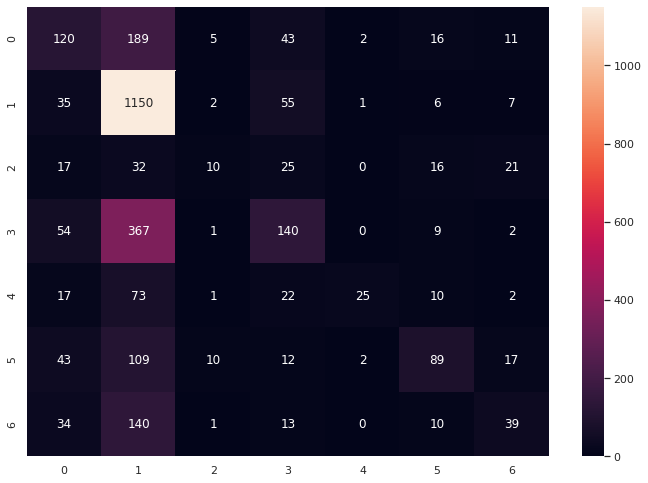

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
cf_matrix = confusion_matrix(preds, Y_test)
sns.heatmap(cf_matrix,  fmt="g", annot=True)

### SVM

Support Vector Machine(SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. 

In the SVM algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. 

Then, we perform classification by finding the best hyper-plane that differentiates the two classes.

<img src="http://en.proft.me/media/science/svm_classification.png" width=300>

The classification function of new element x SVM is:

$y(x) = \sum_{i=1}^m{w_i^* \phi(x) + w_o^*}$

Where $\phi$ is the base function used in the classifier.

In our experiments we use rbf kernel function to "project" data (non-linear transformation) into a new high-dimensional feature space $F$ where we aim to find a linear separation of our original data. 

In our experiment we use the **RBF kernel**.
It is parameterized by a length scale parameter $l$, which can either be a scalar or a vector with the same number of dimensions as the inputs X. 

The kernel is given by:

$k(x_i, x_j) = exp(-\frac{d(x_i, x_k)^2}{2l^2})$ 

where $x_i$ and $x_j$ are two dataset examples and $d(x_i, x_j)$ is the Eucledian distance.



In [ ]:
from sklearn.svm import SVC

In our model selection step we search for best parametrization of $C$ and $\gamma$. Where $C$ is the regularization parameter of SVM and $\gamma$ is the $l$ parametere of RBF kernel.

In [ ]:
# logistic regression parameters
SVM_parameters = {
    "C":[1, 0.6, 0.2],
    "gamma" : [0.1, 1],
    "kernel":["rbf"],
    "class_weight":["balanced"],
}

In order to perform the classification task with our data we standardize the data (mean 0 and variance 1) using the Standard Scaler (sci-kit learn library).

In [ ]:
def normalize_data(x_train, y_train, x_val, y_val):
  train_reshape = x_train.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3)
  val_reshape = x_val.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3)
  scaler = StandardScaler()
  scaler.fit(train_reshape)
  
  return scaler.transform(train_reshape), y_train, scaler.transform(val_reshape), y_val


In [ ]:
# init the model
estimator = SVC()
results = {}
datasets = {
    "base":normalize_data(X_train, Y_train, X_val, Y_val), 
    "base_augmented":normalize_data(augmented_train, Y_train, X_val, Y_val), 
    "undersampled":normalize_data(np.array(augmented_train_undersampled), Y_train_undersampled, X_val, Y_val), 
    "combined":normalize_data(np.array(augmented_train_combined), Y_train_combined, X_val, Y_val)
    }

for d in datasets:
  r = grid_search(grid=SVM_parameters, 
                      model=estimator, 
                      X_train=datasets[d][0], 
                      Y_train=datasets[d][1], 
                      X_val = datasets[d][2], 
                      Y_val=datasets[d][3]
                  )
  results[d] = r

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [2:40:14<00:00, 1602.49s/it]


In [ ]:
save_pickle(results, "SVM_grid_search", drive= False)

In [ ]:
for r in results:
  results[r]["dataset"] = r

all_models_results = pd.concat([
                                results["base"],
                                results["base_augmented"],
                                results["undersampled"],
                                results["combined"],
                                ])

all_models_results.sort_values("f1", ascending=False).to_csv("SVM_datasets_performances.csv")
all_models_results.sort_values("f1", ascending=False)

,params,accuracy,precision,recall,f1,dataset
0,"{'C': 1, 'class_weight': 'balanced', 'gamma': ...",0.672655,0.142857,0.096094,0.114899,base
1,"{'C': 1, 'class_weight': 'balanced', 'gamma': ...",0.672655,0.142857,0.096094,0.114899,base
4,"{'C': 0.2, 'class_weight': 'balanced', 'gamma'...",0.672655,0.142857,0.096094,0.114899,combined
3,"{'C': 0.6, 'class_weight': 'balanced', 'gamma'...",0.672655,0.142857,0.096094,0.114899,combined
2,"{'C': 0.6, 'class_weight': 'balanced', 'gamma'...",0.672655,0.142857,0.096094,0.114899,combined
1,"{'C': 1, 'class_weight': 'balanced', 'gamma': ...",0.672655,0.142857,0.096094,0.114899,combined
0,"{'C': 1, 'class_weight': 'balanced', 'gamma': ...",0.672655,0.142857,0.096094,0.114899,combined
3,"{'C': 0.6, 'class_weight': 'balanced', 'gamma'...",0.672655,0.142857,0.096094,0.114899,undersampled
2,"{'C': 0.6, 'class_weight': 'balanced', 'gamma'...",0.672655,0.142857,0.096094,0.114899,undersampled
5,"{'C': 0.2, 'class_weight': 'balanced', 'gamma'...",0.672655,0.142857,0.096094,0.114899,combined


In [ ]:
# best model
best_svm_model = all_models_results.sort_values("f1", ascending=False).values[0]
best = SVC()
print(best_svm_model[0])
best.set_params(**best_svm_model[0])
best.fit(datasets[best_svm_model[5]][0], datasets[best_svm_model[5]][1])

{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


SVC(C=1, class_weight='balanced', gamma=0.1)

In [ ]:
scaler = StandardScaler()
scaler.fit(datasets[best_svm_model[5]][0])

preds = best.predict(scaler.transform(X_test))

test_results = pd.DataFrame()

test_results["accuracy"] = [accuracy_score(preds, Y_test)]
test_results["precision"] = [precision_score(preds, Y_test, average="macro")]
test_results["recall"] = [recall_score(preds, Y_test, average="macro")]
test_results["f1"] = [f1_score(preds, Y_test, average="macro")]

test_results.to_csv("SVM_test_results.csv")
test_results

In [ ]:
preds = best.predict(scaler.transform(X_test.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3)))

test_results = pd.DataFrame()

test_results["accuracy"] = [accuracy_score(preds, Y_test)]
test_results["precision"] = [precision_score(preds, Y_test, average="macro")]
test_results["recall"] = [recall_score(preds, Y_test, average="macro")]
test_results["f1"] = [f1_score(preds, Y_test, average="macro")]
test_results["balanced_accuracy"] = [balanced_accuracy_score(preds, Y_test)]

test_results.to_csv("SVM_test_results.csv")
test_results

,accuracy,precision,recall,f1
0,0.685524,0.142857,0.097932,0.116204


In [ ]:
test_results["balanced_accuracy"] = [balanced_accuracy_score(preds, Y_test, adjusted = True)]
test_results

,accuracy,precision,recall,f1,balanced_accuracy
0,0.685524,0.142857,0.097932,0.116204,-inf


<AxesSubplot:>

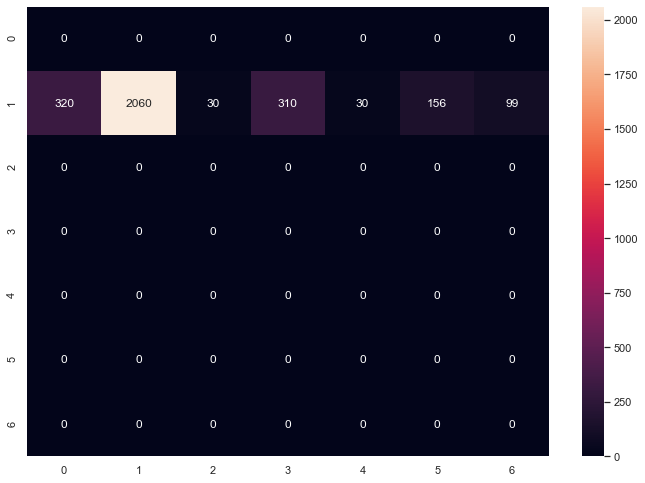

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
cf_matrix = confusion_matrix(preds, Y_test)
sns.heatmap(cf_matrix,  fmt="g", annot=True)

In [ ]:
px.bar(x=list(range(0,7)), y=best.n_support_, title= "Support Vectors number for each class")

## Deep Learning

In our experiments we investigate CNN (SOTA in image processing).

<img src="https://miro.medium.com/max/2636/1*3fA77_mLNiJTSgZFhYnU0Q.png" width=350>

In [ ]:
# NN hyperparameters

# batch size
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 128

# image size (flatten)
INPUT_SIZE = IMAGE_SIZE*IMAGE_SIZE*3

# num of classes
NUM_CLASSES = len(np.unique(Y_train))

# epochs
MAX_EPOCHS = 10

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback 
from sklearn.metrics import classification_report

In [ ]:
class MetricsCallback(Callback):
  def __init__(self, test_data, y_true):
      self.y_true = y_true
      self.test_data = test_data
      self.results = []
      

  def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.test_data)
        y_pred = tf.argmax(y_pred,axis=1)
        report_dictionary = classification_report(self.y_true, y_pred, output_dict = True)
        print(classification_report(self.y_true,y_pred,output_dict=False))
        self.results.append(report_dictionary)

### MLP

In [ ]:
def MLPModel(input_dim, num_classes, dropout):
  # Create the model
  model = Sequential()
  model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
  model.add(Flatten())
  model.add(Dense(350, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model

In [ ]:
def create_mlp_model(dropout=0.3, lr=2e-2, train_batch_size = 16):
  # define model
  model = MLPModel(IMAGE_SIZE*IMAGE_SIZE*3, num_classes=NUM_CLASSES, dropout=dropout)
  
  # optimizer and loss
  model.compile(
        tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy", 
        metrics=['accuracy']
        )
  
  # model callbacks
  metrics_callback = MetricsCallback(test_data=X_val, y_true=Y_val)
  
  # early stopping and checkpoint
  callbacks = [
               tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=2e-2, 
                                patience=3, 
                                verbose=1, 
                                mode='min', 
                                baseline=None, 
                                restore_best_weights=True),
               
             tf.keras.callbacks.ModelCheckpoint("/gdrive/My Drive/ML/", 
                                     monitor='val_loss', 
                                     verbose=1, 
                                     save_best_only=True,
                                     save_weights_only=False, 
                                     mode='auto', 
                                     save_freq='epoch'),
             metrics_callback]

  return model, callbacks

In [ ]:
def compute_class_weights(Y_train):
  weights = np.full(7, len(Y_train))
  weights = dict(enumerate(weights))
  for w in weights:
    weights[w] = weights[w] / (NUM_CLASSES * Counter(Y_train)[w] ) 
  return weights

In [ ]:
def mlp_experiment(X_train, Y_train, X_val, Y_val, dropout=0.3, lr=2e-2, train_batch_size = 16):
  model, callbacks = create_mlp_model(dropout, lr, train_batch_size)
  epochs=10
  history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=epochs,
    callbacks=callbacks,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    class_weight=compute_class_weights(Y_train)
  )
  return history, callbacks

In [ ]:
def mlp_hyp_tuning(datasets, hyperparams):
  results = {}
  for d in datasets:
    data = datasets[d]
    for hyp in hyperparams:
      h, c = mlp_experiment(X_train=data[0],Y_train=data[1],X_val=data[2], Y_val=data[3], 
                            dropout=hyp["dropout"], 
                            lr=hyp["lr"], 
                            train_batch_size=hyp["train_batch_size"])
      
      best_epoch = np.argmin(h.history["val_loss"])

      results[f"{d}_{hyp}"] = (h, c[-1].results[best_epoch], best_epoch)
  return results

In [ ]:
mlp_params = [
        {"dropout":0.2, "lr":2e-2, "train_batch_size":64},
        {"dropout":0.3, "lr":3e-2, "train_batch_size":128},

]

datasets = {
    "combined":(np.array(augmented_train_combined), Y_train_combined, X_val, Y_val)
    }
    

mlp_results = mlp_hyp_tuning(datasets=datasets, hyperparams=mlp_params)

In [ ]:
def prettify_results(res):
  exp = pd.DataFrame()
  models = []
  accuracies = []
  precisions = []
  recalls = []
  f1s = []

  for r in res:
    models.append(r)
    df = pd.DataFrame(res[r][1])
    accuracies.append(df["accuracy"].values[0])
    precisions.append(df["macro avg"].values[0])
    recalls.append(df["macro avg"].values[1])
    f1s.append(df["macro avg"].values[2])

  exp["model"] = models
  exp["accuracy"] = accuracies
  exp["precision"] = precisions
  exp["recall"] = recalls
  exp["f1"] = f1s

  return exp
presults = prettify_results(mlp_results)

In [ ]:
presults.to_csv("/gdrive/My Drive/ML/MLP/MLP_hyperparameterization.csv")
presults

,model,accuracy,precision,recall,f1
0,"undersampled_{'dropout': 0.4, 'lr': 0.001, 'tr...",0.640719,0.135992,0.158341,0.139800
1,"undersampled_{'dropout': 0.4, 'lr': 0.002, 'tr...",0.649701,0.092814,0.142857,0.112523
2,"undersampled_{'dropout': 0.4, 'lr': 0.03, 'tra...",0.649701,0.092814,0.142857,0.112523
3,"combined_{'dropout': 0.4, 'lr': 0.001, 'train_...",0.010978,0.001568,0.142857,0.003103
4,"combined_{'dropout': 0.4, 'lr': 0.002, 'train_...",0.116766,0.016681,0.142857,0.029874
5,"combined_{'dropout': 0.4, 'lr': 0.03, 'train_b...",0.025948,0.003707,0.142857,0.007226


Text(0, 0.5, 'loss')

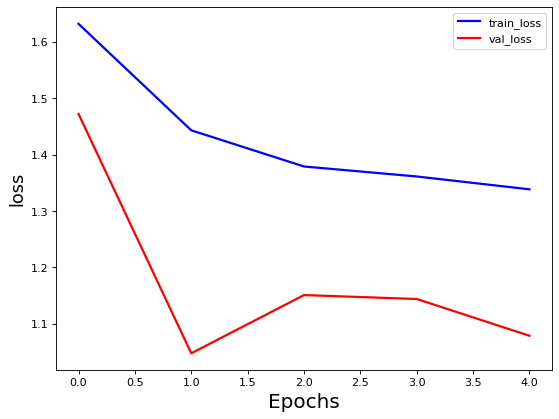

In [ ]:
from matplotlib.pyplot import figure
best = presults.sort_values("f1", ascending=False).values[0]
figure(figsize=(8, 6), dpi=80)
history = mlp_results[str(best[0])][0]
plt.plot(history.epoch, history.history["loss"], color='blue',linewidth=2, markersize=12, label="train_loss")
plt.plot(history.epoch, history.history["val_loss"], color='red',linewidth=2, markersize=12,  label="val_loss")
plt.legend()
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('loss', fontsize=16)

In [ ]:
val_results = pd.DataFrame(mlp_results[str(best[0])][1]).transpose()
val_results

,precision,recall,f1-score,support
0,0.290909,0.146789,0.195122,109.000000
1,0.661035,0.961598,0.783479,651.000000
2,0.000000,0.000000,0.000000,11.000000
3,0.000000,0.000000,0.000000,117.000000
4,0.000000,0.000000,0.000000,26.000000
5,0.000000,0.000000,0.000000,62.000000
6,0.000000,0.000000,0.000000,26.000000
accuracy,0.640719,0.640719,0.640719,0.640719
macro avg,0.135992,0.158341,0.139800,1002.000000
weighted avg,0.461121,0.640719,0.530253,1002.000000


In [ ]:
best_epoch = mlp_results[str(best[0])][2]
best_epoch

9

In [ ]:
px.bar( x=val_results.index[:-3], y=val_results["f1-score"].values[:-3], title="Classes F1")

In [ ]:
import ast

In [ ]:
dataset_name = best[0].split("_")[0]
best_data = datasets[dataset_name]
best_conf = mlp_params[mlp_params.index(ast.literal_eval(best[0].split(dataset_name+"_")[1]))]
best_conf

{'dropout': 0.4, 'kernel_size': 3, 'lr': 0.001, 'train_batch_size': 128}

In [ ]:
best_model, callbacks = create_mlp_model(best_conf["dropout"], best_conf["lr"], best_conf["train_batch_size"], best_conf["kernel_size"])

In [ ]:
epochs=best_epoch + 1
history = best_model.fit(
  X_train,
  Y_train,
  validation_data=(X_val, Y_val),
  epochs=epochs,
  callbacks=[callbacks[-1]],
  batch_size=TRAIN_BATCH_SIZE,
  shuffle=True
)

In [ ]:
test_preds = np.argmax(best_model.predict(X_test), axis=1)
f1_score(test_preds, Y_test, average="macro")

0.4134459662900767

In [ ]:
test_results = pd.DataFrame()

test_results["accuracy"] = [accuracy_score(preds, Y_test)]
test_results["precision"] = [precision_score(preds, Y_test, average="macro")]
test_results["recall"] = [recall_score(preds, Y_test, average="macro")]
test_results["f1"] = [f1_score(preds, Y_test, average="macro")]

test_results.to_csv("/gdrive/My Drive/ML/ML/mlp_test_results.csv")
test_results

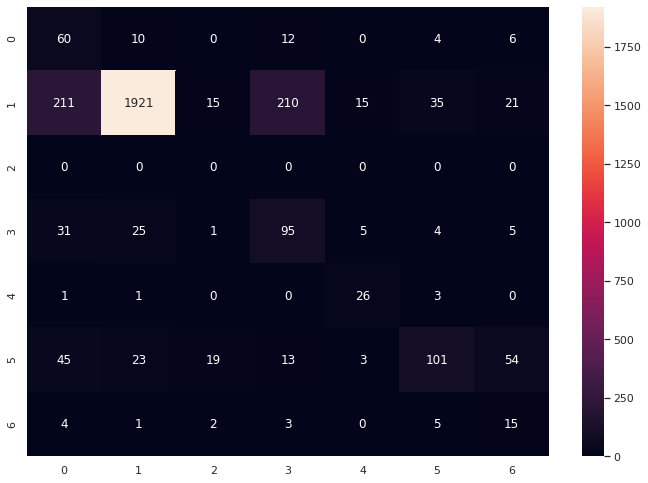

In [ ]:
# confusion matrix
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
cf_matrix = confusion_matrix(test_preds, Y_test)
sns.heatmap(cf_matrix,  fmt="g", annot=True)

### CNN

We use a CNN architecture to perform our classification task. 


![cnn](https://miro.medium.com/max/875/1*ulfFYH5HbWpLTIfuebj5mQ.gif)


A Convolutional Neural Network, also known as CNN or ConvNet, is a class of neural networks that specializes in processing data that has a **grid-like** topology, such as an image. It contains a series of pixels arranged in a grid-like fashion that contains pixel values to denote how bright and what color each pixel should be.

The layers are arranged in such a way so that they detect simpler patterns first (lines, curves, etc.) and more complex patterns (faces, objects, etc.) further along. By using a CNN, one can enable sight to computers.

The main operations of a CNN are:

- **Convolution**
  - Padding
  - Stride
  - Kernel

- **Pooling**
  - Max Pooling
  - Avg Pooling


**Activation functions**

In all of our layer we use the ReLU activation function:

$f(x) = max(0, x)$


<img src="https://miro.medium.com/max/2052/1*DfMRHwxY1gyyDmrIAd-gjQ.png" width="280" />


In the output layer we use the softmax function that give us a vector of values between 0 and 1.

$s(x) = \frac{e^{z_i}}{\sum_{r=1}^K e^{z_r}}$



**Cost function**

We use the cross-entropy loss (multi-class version):

$L(x) = -\sum_{c=1}^My_{x,c}\log(p_{x,c})$

In [ ]:
def Skin_Lesion_Model(dropout):
  model = Sequential()
  model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
  model.add(Conv2D(16, kernel_size = (3,3), input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), activation = 'relu', padding = 'same'))
  model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
  model.add(MaxPool2D(pool_size = (2,2)))

  model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
  model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
  model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

  model.add(Dropout(dropout))

  model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
  model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
  model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

  model.add(Flatten())

  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(7, activation='softmax'))
  return model


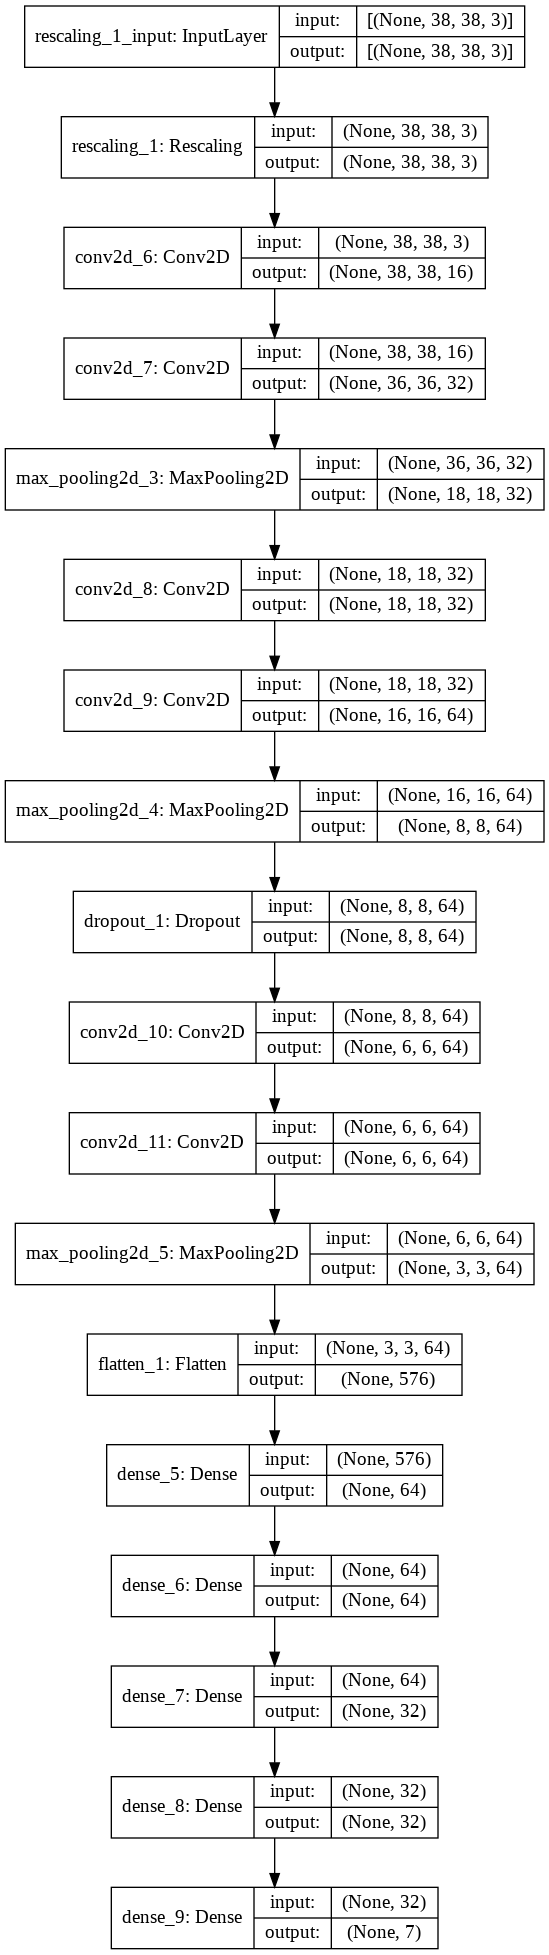

In [ ]:
tf.keras.utils.plot_model(Skin_Lesion_Model(0.3), to_file="./net.png", show_shapes=True)

**Early Stopping**

In our experiments we use a Early Stopping regularization to avoid overfitting. We monitoring the validation loss value during the training and we stop it when the validation loss doesn't increase for 3 epochs. This strategy allow us to prevent the overfitting and find the model with lowest loss over the validation set.

In [ ]:
def create_cnn_model(dropout=0.3, lr=2e-2, train_batch_size = 16):
  # define model
  model = Skin_Lesion_Model(dropout,)
  
  # optimizer and loss
  model.compile(
        tf.keras.optimizers.Adam( learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy']
        )
  
  # model callbacks
  metrics_callback = MetricsCallback(test_data=X_val, y_true=Y_val)
  
  # early stopping and checkpoint
  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=5e-2, 
                                patience=3, 
                                verbose=1, 
                                mode='min', 
                                baseline=None, 
                                restore_best_weights=True),
               
             tf.keras.callbacks.ModelCheckpoint("/gdrive/My Drive/ML/",        
                                     monitor='val_loss', 
                                     verbose=1, 
                                     save_best_only=True,
                                     save_weights_only=False, 
                                     mode='auto', 
                                     save_freq='epoch'),
             metrics_callback
             ]

  return model, callbacks

**Class weights**

It is highly possible that the distribution of discrete values will be very different. Due to this difference in each class, the algorithms tend to get biased towards the majority values present and don’t perform well on the minority values.

This difference in class frequencies affects the overall predictability of the model. In order to avoid this problem we adopt a class weight strategy.

The weights vector is $w = (w_1, ..., w_n)$ where each $w_i$ is:

- $w_i = \frac{|T|}{|C| * |C_i|} $

  - $w_i$ is the weight for each class(i signifies the class)
  - $|T|$ is the number of examples in the training set
  - $|C_i|$ is the number of elements in class $C_i$
  - $|C|$ is the number of classes




In [ ]:
def compute_class_weights(Y_train):
  weights = np.full(NUM_CLASSES, len(Y_train))
  weights = dict(enumerate(weights))
  for w in weights:
    weights[w] = weights[w] / (NUM_CLASSES * Counter(Y_train)[w] ) 
  return weights

In [ ]:
def cnn_experiment(X_train, Y_train, X_val, Y_val, dropout=0.3, lr=2e-2, train_batch_size = 16):
  model, callbacks = create_cnn_model(dropout, lr, train_batch_size)
  epochs=10
  history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=epochs,
    callbacks=callbacks,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    class_weight = compute_class_weights(Y_train)
  )
  return history, callbacks

In [ ]:
def hyp_tuning(datasets, hyperparams):
  results = {}
  for d in datasets:
    data = datasets[d]
    for hyp in hyperparams:
      h, c = cnn_experiment(X_train=data[0],Y_train=data[1],X_val=data[2], Y_val=data[3], 
                            dropout=hyp["dropout"], 
                            lr=hyp["lr"], 
                            train_batch_size=hyp["train_batch_size"], 
                           )
      
      best_epoch = np.argmin(h.history["val_loss"])

      results[f"{d}_{hyp}"] = (h, c[-1].results[best_epoch], best_epoch)
  return results

In [ ]:
cnn_params = [
        {"dropout":0.3, "lr":1e-3, "train_batch_size":128, },
        {"dropout":0.4, "lr":2e-3, "train_batch_size":64, },
        {"dropout":0.4, "lr":3e-2, "train_batch_size":128},

]

datasets = {
    "base": (X_train, Y_train, X_val, Y_val),
    "augmented": (np.array(augmented_train), Y_train, X_val, Y_val),
    "undersampled":(np.array(augmented_train_undersampled), Y_train_undersampled, X_val, Y_val), 
    "combined":(np.array(augmented_train_combined), Y_train_combined, X_val, Y_val)
    }
    

cnn_results = hyp_tuning(datasets=datasets, hyperparams=cnn_params)

Epoch 1/10
282/282 [==============================] - 5s 13ms/step - loss: 1.9449 - accuracy: 0.3822 - val_loss: 2.0075 - val_accuracy: 0.0509

Epoch 00001: val_loss improved from inf to 2.00754, saving model to /gdrive/My Drive/ML/
INFO:tensorflow:Assets written to: /gdrive/My Drive/ML/assets
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       107
           1       0.00      0.00      0.00       674
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00       118
           4       0.00      0.00      0.00        13
           5       0.05      1.00      0.10        51
           6       0.00      0.00      0.00        30

    accuracy                           0.05      1002
   macro avg       0.01      0.14      0.01      1002
weighted avg       0.00      0.05      0.00      1002

Epoch 2/10
282/282 [==============================] - 3s 11ms/step - loss: 1.9482 - accuracy: 0.1460 - val_l

In [ ]:
def prettify_results(res):
  exp = pd.DataFrame()
  models = []
  accuracies = []
  precisions = []
  recalls = []
  f1s = []

  for r in res:
    models.append(r)
    df = pd.DataFrame(res[r][1])
    accuracies.append(df["accuracy"].values[0])
    precisions.append(df["macro avg"].values[0])
    recalls.append(df["macro avg"].values[1])
    f1s.append(df["macro avg"].values[2])

  exp["model"] = models
  exp["accuracy"] = accuracies
  exp["precision"] = precisions
  exp["recall"] = recalls
  exp["f1"] = f1s

  return exp
presults = prettify_results(cnn_results)

In [ ]:
presults.to_csv("/gdrive/My Drive/ML/CNN_hyperparameterization.csv")


,model,accuracy,precision,recall,f1
0,"base_{'dropout': 0.3, 'lr': 0.001, 'train_batc...",0.672655,0.096094,0.142857,0.114899
1,"base_{'dropout': 0.4, 'lr': 0.002, 'train_batc...",0.105788,0.128570,0.163417,0.038246
2,"base_{'dropout': 0.4, 'lr': 0.03, 'train_batch...",0.672655,0.096094,0.142857,0.114899
3,"augmented_{'dropout': 0.3, 'lr': 0.001, 'train...",0.672655,0.096094,0.142857,0.114899
4,"augmented_{'dropout': 0.4, 'lr': 0.002, 'train...",0.672655,0.096094,0.142857,0.114899
5,"augmented_{'dropout': 0.4, 'lr': 0.03, 'train_...",0.106786,0.015255,0.142857,0.027567
6,"undersampled_{'dropout': 0.3, 'lr': 0.001, 'tr...",0.106786,0.015255,0.142857,0.027567
7,"undersampled_{'dropout': 0.4, 'lr': 0.002, 'tr...",0.566866,0.115887,0.230017,0.122320
8,"undersampled_{'dropout': 0.4, 'lr': 0.03, 'tra...",0.012974,0.001853,0.142857,0.003659
9,"combined_{'dropout': 0.3, 'lr': 0.001, 'train_...",0.613772,0.439678,0.620589,0.474917


Text(0, 0.5, 'loss')

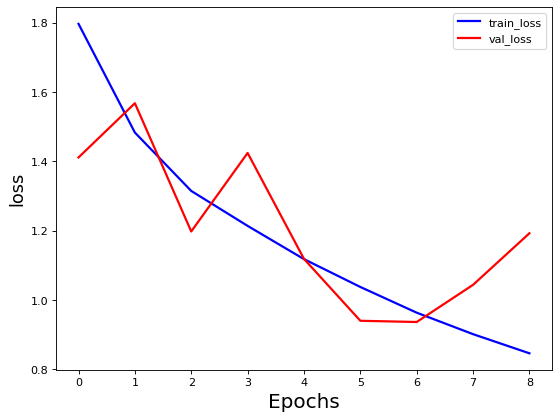

In [ ]:
from matplotlib.pyplot import figure
best = presults.sort_values("f1", ascending=False).values[0]
figure(figsize=(8, 6), dpi=80)
history = cnn_results[str(best[0])][0]
plt.plot(history.epoch, history.history["loss"], color='blue',linewidth=2, markersize=12, label="train_loss")
plt.plot(history.epoch, history.history["val_loss"], color='red',linewidth=2, markersize=12,  label="val_loss")
plt.legend()
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('loss', fontsize=16)

In [ ]:
val_results = pd.DataFrame(cnn_results[str(best[0])][1]).transpose()
val_results

,precision,recall,f1-score,support
0,0.493671,0.364486,0.419355,107.000000
1,0.936170,0.652819,0.769231,674.000000
2,0.131579,0.555556,0.212766,9.000000
3,0.272358,0.567797,0.368132,118.000000
4,0.480000,0.923077,0.631579,13.000000
5,0.532258,0.647059,0.584071,51.000000
6,0.231707,0.633333,0.339286,30.000000
accuracy,0.613772,0.613772,0.613772,0.613772
macro avg,0.439678,0.620589,0.474917,1002.000000
weighted avg,0.755948,0.613772,0.655553,1002.000000


In [ ]:
best_epoch = cnn_results[str(best[0])][2]
best_epoch

6

In [ ]:
px.bar( x=val_results.index[:-3], y=val_results["f1-score"].values[:-3], title="Classes F1")

In [ ]:
import ast

In [ ]:
dataset_name = best[0].split("_")[0]
best_data = datasets[dataset_name]
best_conf = cnn_params[cnn_params.index(ast.literal_eval(best[0].split(dataset_name+"_")[1]))]
best_conf

{'dropout': 0.3, 'lr': 0.001, 'train_batch_size': 128}

In [ ]:
best_model, callbacks = create_cnn_model(best_conf["dropout"], best_conf["lr"], best_conf["train_batch_size"])

In [ ]:
np.array(X_train_combined).shape

(17500, 38, 38, 3)

In [ ]:
# retrain best model
epochs = 10
history = best_model.fit(
  np.array(augmented_train_combined),
  Y_train_combined,
  validation_data=(X_val, Y_val),
  epochs=epochs,
  callbacks=callbacks,
  batch_size=TRAIN_BATCH_SIZE,
  shuffle=True,
  class_weight=compute_class_weights(Y_train_combined)
)

Epoch 1/10
547/547 [==============================] - 7s 11ms/step - loss: 1.7198 - accuracy: 0.2721 - val_loss: 1.4341 - val_accuracy: 0.5399

Epoch 00001: val_loss improved from inf to 1.43409, saving model to /gdrive/My Drive/ML/
INFO:tensorflow:Assets written to: /gdrive/My Drive/ML/assets
              precision    recall  f1-score   support

           0       0.21      0.32      0.25       107
           1       0.82      0.66      0.73       674
           2       0.25      0.11      0.15         9
           3       0.19      0.15      0.17       118
           4       0.17      0.85      0.28        13
           5       0.25      0.59      0.36        51
           6       0.12      0.07      0.09        30

    accuracy                           0.54      1002
   macro avg       0.29      0.39      0.29      1002
weighted avg       0.62      0.54      0.56      1002

Epoch 2/10
547/547 [==============================] - 6s 11ms/step - loss: 1.3889 - accuracy: 0.4237 - val_l

In [ ]:
# test evaluation
preds = np.argmax(best_model.predict(X_test), axis=1)
f1_score(preds, Y_test, average="macro")

0.46951310576462457

In [ ]:
test_results = pd.DataFrame()

test_results["accuracy"] = [accuracy_score(preds, Y_test)]
test_results["precision"] = [precision_score(preds, Y_test, average="macro")]
test_results["recall"] = [recall_score(preds, Y_test, average="macro")]
test_results["f1"] = [f1_score(preds, Y_test, average="macro")]

test_results.to_csv("/gdrive/My Drive/ML/cnn_test_results.csv")
test_results

,accuracy,precision,recall,f1
0,0.604659,0.608179,0.42231,0.469513


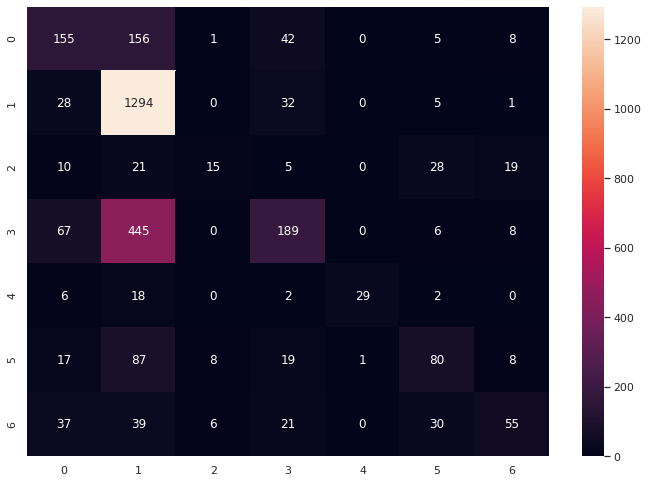

In [ ]:
# confusion matrix
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
cf_matrix = confusion_matrix(preds, Y_test)
sns.heatmap(cf_matrix,  fmt="g", annot=True)

## Ensamble Learning

Improve performance by combining multiple models, in some way, instead of using a single model.

- Train a committee of $L$ different models and make predictions by averaging the
predictions made by each model on dataset samplings (**bagging**)

- Train different models in sequence: the error function used to train a model depend on the performance of previous models (**boosting**)

In our experiments we use the boosting strategy.

Boosting produces a sequence of weak classifiers $y_m(x)$ for $m = 1, . . . ,M$ whose predictions are then combined through a weighted majority to produce the final prediction.

$y(x) = sgn(\sum_{j=1}^M{\alpha_j y_j(x)})$ (in binary classification)


### XGBoosting

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. 

XGBoost provides a parallel tree boosting (GBDT) that solve many data science problems in a fast and accurate way.

**Gradient-boosted decision trees (GBDT)**

In [ ]:
import xgboost as xgb


def init_XGB():
  return xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=-1, nthread=None,
                                            objective='multi:softprob',
                                            random_state=1855, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=0)

In [ ]:
def datasets_eval(model, X_train, X_val, Y_train, Y_val):
  precisions, recalls, f1s, accuracies = [], [], [], []  
  results = pd.DataFrame()
  # training
  model.fit(X_train, Y_train)

  # measure on validation set
  val_preds = model.predict(X_val)
  precisions.append(precision_score(val_preds, Y_val, average="macro"))
  recalls.append(recall_score(val_preds, Y_val, average="macro"))
  f1s.append(f1_score(val_preds, Y_val, average="macro"))
  accuracies.append(accuracy_score(val_preds, Y_val))

  results["accuracy"] = accuracies
  results["precision"] = precisions
  results["recall"] = recalls
  results["f1"] = f1s


  return results

In [ ]:
datasets = {
    "base":(X_train.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_train, X_val.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_val), 
    "base_augmented":(augmented_train.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_train,  X_val.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_val), 
    "undersampled":(np.array(augmented_train_undersampled).reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_train_undersampled, X_val.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_val), 
    "combined":(np.array(augmented_train_combined).reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_train_combined, X_val.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3), Y_val)
    }

results = {}

In [ ]:
for d in tqdm(datasets):
  m = init_XGB()
  r = datasets_eval(m, datasets[d][0], datasets[d][2], datasets[d][1], datasets[d][3])
  results[d] = r 


100%|██████████| 4/4 [39:12<00:00, 588.17s/it]


In [ ]:
save_pickle(results, "xgboosting_results")

In [ ]:
for r in results:
  results[r]["dataset"] = r

all_models_results = pd.concat([
                                results["base"],
                                results["base_augmented"],
                                results["undersampled"],
                                results["combined"],
                                ])

best = all_models_results.sort_values("f1", ascending=False).values[0]
all_models_results.sort_values("f1", ascending=False)


,accuracy,precision,recall,f1,dataset
0,0.689621,0.352245,0.425153,0.373104,undersampled
0,0.521956,0.509492,0.334140,0.353343,combined
0,0.718563,0.310041,0.510800,0.352380,base
0,0.703593,0.289600,0.514015,0.314433,base_augmented


In [ ]:
all_models_results.sort_values("f1", ascending=False).to_csv("/gdrive/My Drive/ML/xgboost_validation_results.csv")

In [ ]:
best = best[-1]

In [ ]:
m = init_XGB()
m.fit(datasets[best][0], datasets[best][1])
preds = m.predict(X_test.reshape(-1, IMAGE_SIZE*IMAGE_SIZE*3))

In [ ]:
test_results = pd.DataFrame()

test_results["accuracy"] = [accuracy_score(preds, Y_test)]
test_results["precision"] = [precision_score(preds, Y_test, average="macro")]
test_results["recall"] = [recall_score(preds, Y_test, average="macro")]
test_results["f1"] = [f1_score(preds, Y_test, average="macro")]

test_results.to_csv("/gdrive/My Drive/ML/XGBoost_test_results.csv")
test_results

,accuracy,precision,recall,f1
0,0.70416,0.348986,0.487715,0.371332


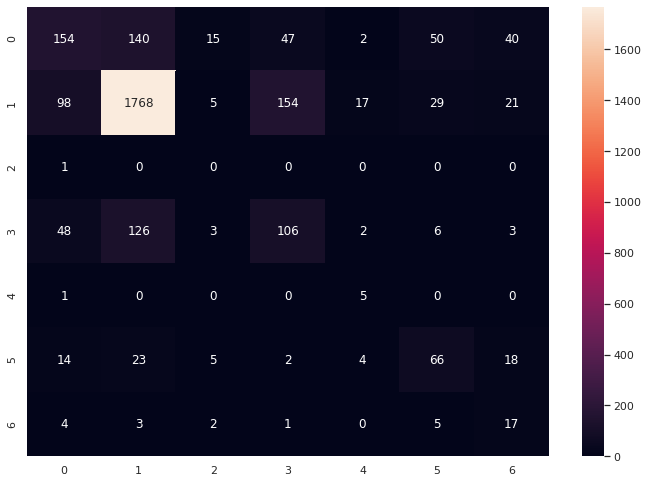

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
cf_matrix = confusion_matrix(preds, Y_test)
sns.heatmap(cf_matrix,  fmt="g", annot=True)

# Model comparison

At the end of our experiments we compare all model results in the following way. 

We take the best model over validation set for each classifier (dataset-hyperparameters) and then we measure all of them over the test set.

The results are showed in the next figure. The **CNN model** achieved the best macro-f1 over the test set (same over validation set). 

The final results confirms the powerness of CNN in image classification tasks but also the good performances of **boosting techniques** (XGBoosting). 

In [ ]:
log_regr = pd.read_csv("/gdrive/My Drive/ML/LogisticRegression/logistic_regression_test_results.csv")
cnn = pd.read_csv("/gdrive/My Drive/ML/CNN/cnn_test_results.csv")
xgboost_res = pd.read_csv("/gdrive/My Drive/ML/XGBoosting/XGBoost_test_results.csv")
random_classifier = pd.read_csv("/gdrive/My Drive/ML/random_test_results.csv")
svm_classifier = pd.read_csv("/gdrive/My Drive/ML/SVM/SVM_test_results.csv")


In [ ]:
model_comparison = pd.DataFrame()
model_comparison = pd.concat([cnn, xgboost_res,log_regr, svm_classifier, random_classifier ])
model_comparison['model'] = ['cnn', 'xgboost', 'logistic_regression', 'svm', 'random']
model_comparison
px.bar(model_comparison, x='model', y='f1', color= 'model')



**Challenge results**

Balanced Multi-class Accuracy

BACC = $\lambda = \frac{1}{l} \sum_{i=1}^{l}\frac{k_i}{n_i}$

Model| Balanced multi-class accuracy
--|--
Competition Winner| 84.50%
40° model| 65.50%
**CNN**| **60.81%**
Logistic Regression | 50.23%
XGBoosting| 48.85%
SVM|14.28%
